In [1]:
from bgunfolding import Sampler, hist, hist_error
from bgunfolding import IBU, ImprIBU
from bgunfolding.metrics import emd

import numpy as np
import matplotlib.pyplot as plt

# Read samples
s = Sampler()
s.read_sample('../data/sample_0.b')

# Load quantities of one sample
f, g, b, A, area_eff, acceptance, eff = s.load_one(i = 0)

# Iterative Bayesian Unfolding
x0 = np.ones(len(f)) / len(f)
ibu = IBU(n_iterations = 10, 
          x0 = x0, 
          smoothing = 'polynomial',
          smoothing_order = 2,
          smoothing_cut_overflow = True)

ibu.fit(f, g, b, A, area_eff, acceptance, eff)
priorf, priorf_err = ibu.predict()

# Improved Iterative Bayesian
impribu = ImprIBU(n_mc = 1000)
impribu.fit(f, g, b, A, area_eff, acceptance, eff)

# Estimate Energy Spectrum
f_est, f_est_err = impribu.mc_unf(priorf, f, full_return = False)

# Earth Mover's Distance
emd_ff = emd(f_est, f, cut_overflow = True)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/home/lars/.local/anaconda3/lib/python3.8/site-packages/fact/io.py:63: UserWarning: BLOSC compression for hdf5 not available, you will not be able to create or read blosc compressed datasets make sure tables and h5py are linked against the same hdf5 library e.g. by installing hdf5 in your system and doing  `pip install --no-binary=tables --no-binary=h5py tables h5py` or using conda
  warnings.warn(


Data succesfully read. (n_samples : 20)


In [2]:
from bgunfolding import hist, hist_error
from astropy import units as u

import matplotlib.pyplot as plt
import numpy as np

In [3]:
bin_width = np.diff(s.bins_true)[1:-1]
bin_centers = 0.5 * (s.bins_true[1:-2] + s.bins_true[2:-1])

In [4]:
# flux
bin_width = np.diff(s.bins_true)[1:-1] * u.GeV
norm = 1 / (impribu.area_eff[1:-1] * u.m ** 2) / (s.obstime * u.hr) / (bin_width)
norm = norm.to(1 / (u.TeV * u.s * u.cm ** 2))
flux_est = f_est[1:-1] * norm

flux_est_std = f_est_err[1:-1] * norm

n_iteration = 10

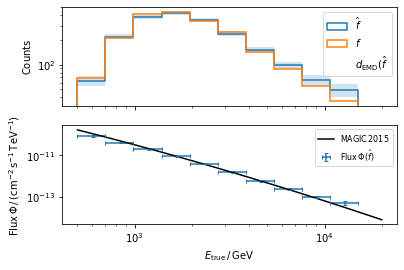

In [5]:
fig, ax = plt.subplots(2, sharex = True)


hist(ax[0], f_est, s.bins_true, label = r'${\hat{f}}$')
hist_error(ax[0], f_est, f_est_err, s.bins_true)
ax[0].set_ylabel(r'$\mathrm{Counts}$')
hist(ax[0], f, s.bins_true, label = r'${f}$')

ax[0].plot([], [], ' ', label= r'$d_{\mathrm{EMD}}(\hat{f}}, f) = %s$' % str(np.round(emd_ff, 2)))

handles, labels = ax[0].get_legend_handles_labels()
order = [1,2,0]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])
           
# flux plot
e_plot = np.logspace(2.7, 4.3, 100)
ax[1].plot(
    e_plot,
    3.23e-11 * (e_plot / 1000)**(-2.47 - 0.24 * np.log10(e_plot / 1000)),
    label=r'$\mathrm{MAGIC\,2015}$',
    color='k'
)

ax[1].errorbar(bin_centers, flux_est.value, 
               xerr = bin_width.value / 2, yerr = flux_est_std.value, 
               ls = 'none', capsize = 2, label = r'$\mathrm{Flux}\,\Phi(\hat{f})$')

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$E_{\mathrm{true}}\,/\,\mathrm{GeV}$')
ax[1].set_ylabel(r'$\mathrm{Flux}\,\Phi\,/\,(\mathrm{cm}^{-2}\,\mathrm{s}^{-1}\,\mathrm{TeV}^{-1})$')
ax[1].legend(loc = 'upper right', fontsize = 8)

data_id = 0
# plt.savefig(f'../plots/{data_id}/impribu_unfolding_flux.pdf')